In [146]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from pandas import DataFrame, Series
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import platform
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

rfc = RandomForestRegressor()
xgb = XGBRegressor()
lr = LinearRegression()
lgbm = LGBMRegressor()
svc = LinearSVC()

In [147]:
# 데이터와 타겟(종속 변수) 준비
X = pd.read_csv('./real_final_feature.csv') # 독립 변수 데이터
y = pd.read_csv('./y_open_0905~_1000(5min)/y_open_1000.csv') # 종속 변수 데이터

# 시간 형태로 변경
X['date'] = pd.to_datetime(X['date'] ,format="%Y-%m-%d")
y['date'] = pd.to_datetime(y['date'],format= "%Y%m%d")

df = pd.merge(X,y, on='date',how='inner')
df.sort_index(ascending=False,inplace=True)
df.drop(columns='Unnamed: 0',inplace=True)
df.set_index('date',inplace=True)

df['open'] = df['open'].shift(-1)
df['kodex_open'] = df['kodex_open'].shift(-1)
df.dropna(inplace=True)


In [148]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
# df 날짜 정렬
df.sort_index(inplace=True)
# X와 y 정의
X = df.drop('open', axis=1)
y = df['open']

# 분리 전 백테스트를 위한 date 생성
dates = df.index

# 학습셋 분리 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)


from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the hyperparameter grids for Lasso, Ridge, ElasticNet

elastic_params = {
    'alpha': np.logspace(-4, 4, 20),
    'l1_ratio': np.linspace(0.01, 1.0, 20)
}

# Initialize the models
elastic = ElasticNet(random_state=42)

elastic_cv = GridSearchCV(elastic, elastic_params, scoring='neg_mean_squared_error', cv=5)

# Fit the models

elastic_cv.fit(X_train, y_train)

# Select the best models
best_model_elastic = elastic_cv.best_estimator_

# Predict on the training set using the best models
y_pred = best_model_elastic.predict(X_test)

# Calculate the performance metrics for each model


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)


In [149]:
# 백테스트 날짜와 함께 결과 DataFrame 생성
results_df = pd.DataFrame({
    'date': dates[-len(y_pred):],  # 테스트 세트와 동일한 길이의 날짜 데이터
    'y_test': y_test.values,  # y_test를 1차원 배열로 변환
    'y_pred': y_pred  # y_pred는 이미 1차원 배열임
})
results_df.set_index('date', inplace=True)
mse, rmse, r2, results_df.head()


(125221.72349442425,
 353.86681604019367,
 0.9589132266575299,
              y_test        y_pred
 date                             
 2022-04-14  34530.0  35058.219737
 2022-04-18  34834.0  34368.834948
 2022-04-19  34708.0  34671.055087
 2022-04-20  35069.0  34946.796240
 2022-04-21  34545.0  34989.634404)

In [150]:
backtest_open = pd.read_csv('./backtest_20/kodex_open.csv')
backtest_open['date'] = pd.to_datetime(backtest_open['date'],format= "%Y%m%d")
backtest_open.set_index('date', inplace=True)
backtest_open

,open
date,
2002-10-14,5354.0
2002-10-15,5483.0
2002-10-16,5442.0
2002-10-17,5661.0
2002-10-18,5729.0
...,...
2023-10-19,32175.0
2023-10-20,31905.0
2023-10-23,31920.0


In [151]:
backtesting = pd.merge(results_df,backtest_open, right_index=True,left_index=True, how='inner')

In [152]:
backtesting

,y_test,y_pred,open
date,,,
2022-04-14,34530.0,35058.219737,34655.0
2022-04-18,34834.0,34368.834948,34636.0
2022-04-19,34708.0,34671.055087,34911.0
2022-04-20,35069.0,34946.796240,34983.0
2022-04-21,34545.0,34989.634404,34713.0
...,...,...,...
2023-10-18,32610.0,32860.531776,32635.0
2023-10-19,31875.0,32660.993007,32175.0
2023-10-20,31930.0,32197.961564,31905.0


In [153]:
backtesting.to_csv('../back_test_final_csv/1000.csv')

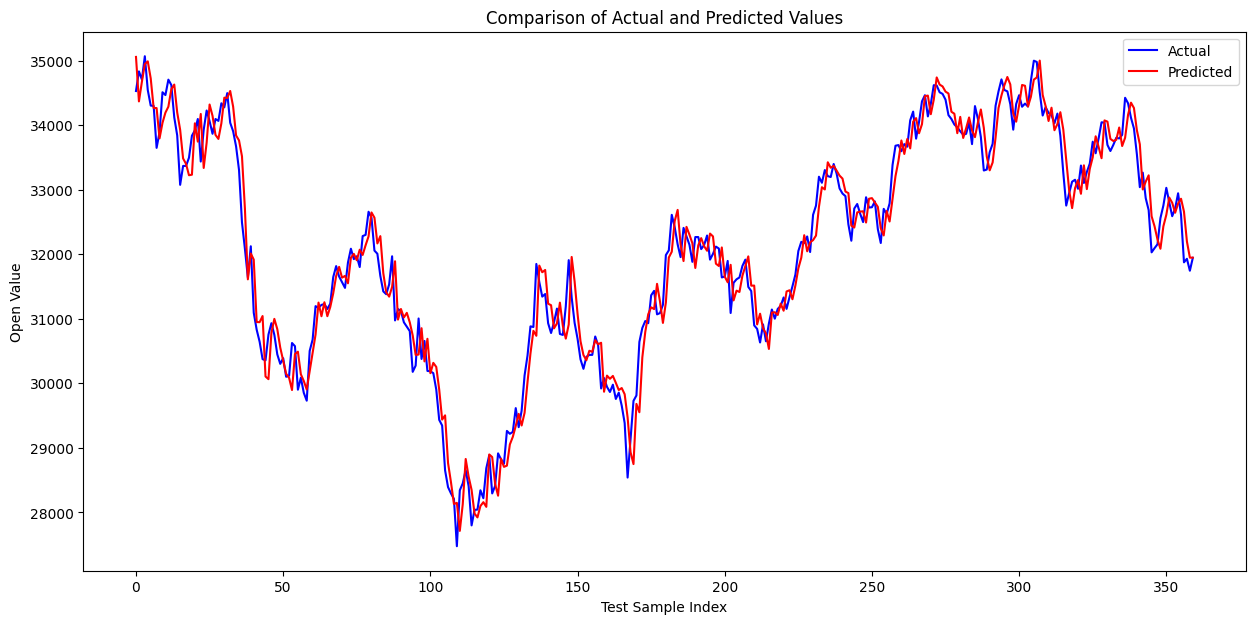

In [154]:
import matplotlib.pyplot as plt

# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test, label='Actual', color='blue')
plt.plot(test_indices, y_pred.flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()


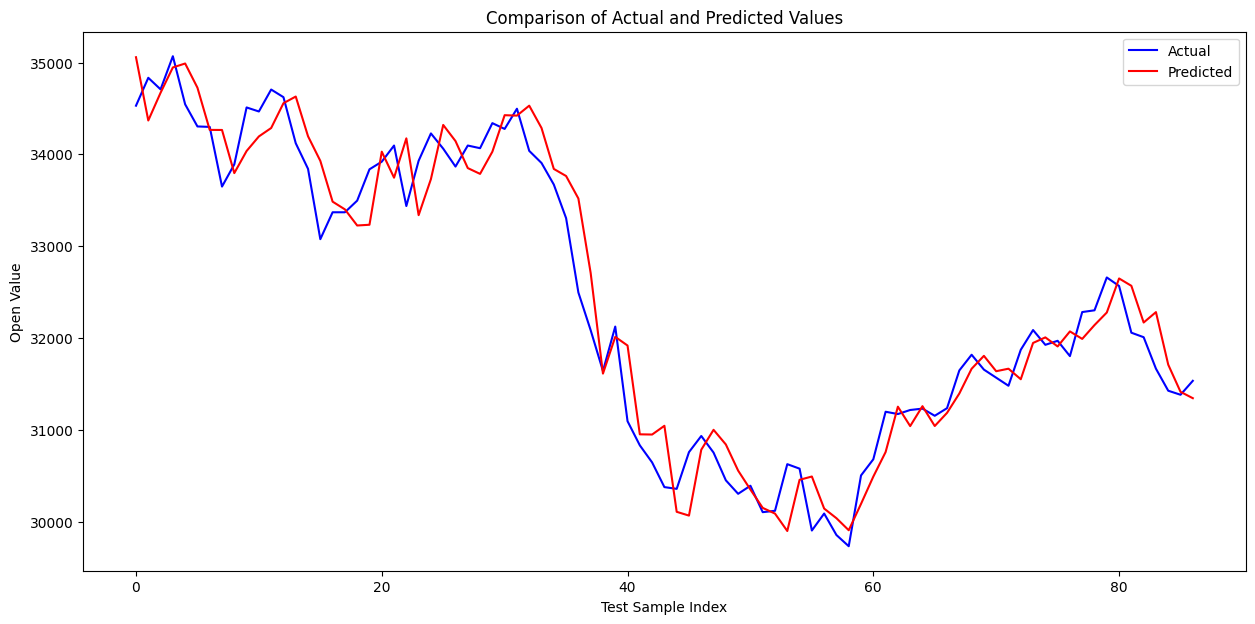

In [155]:
# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test[:87]))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test[:87], label='Actual', color='blue')
plt.plot(test_indices, y_pred[:87].flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()


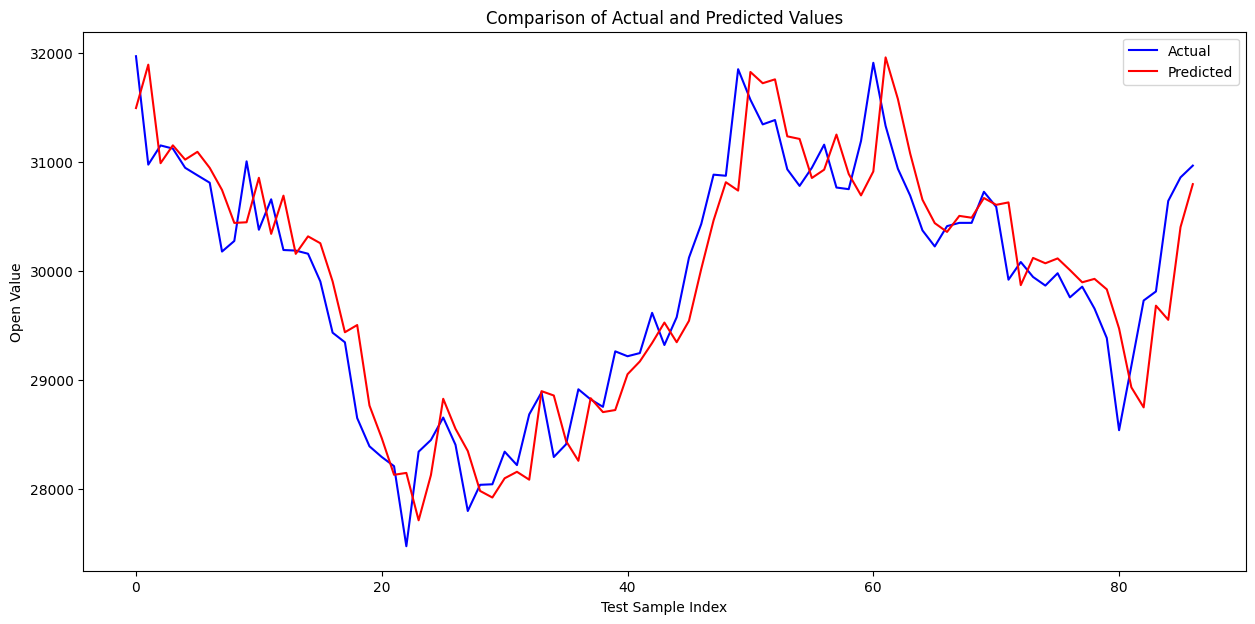

In [156]:
# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test[87:174]))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test[87:174], label='Actual', color='blue')
plt.plot(test_indices, y_pred[87:174].flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()


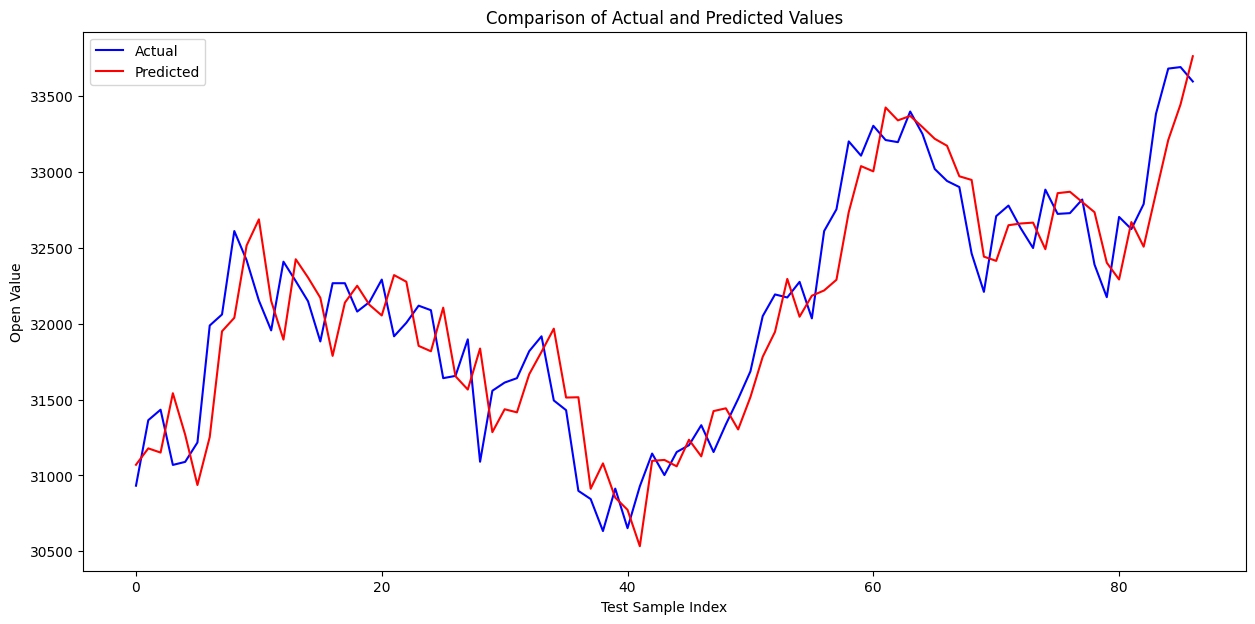

In [157]:
# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test[174:261]))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test[174:261], label='Actual', color='blue')
plt.plot(test_indices, y_pred[174:261].flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()

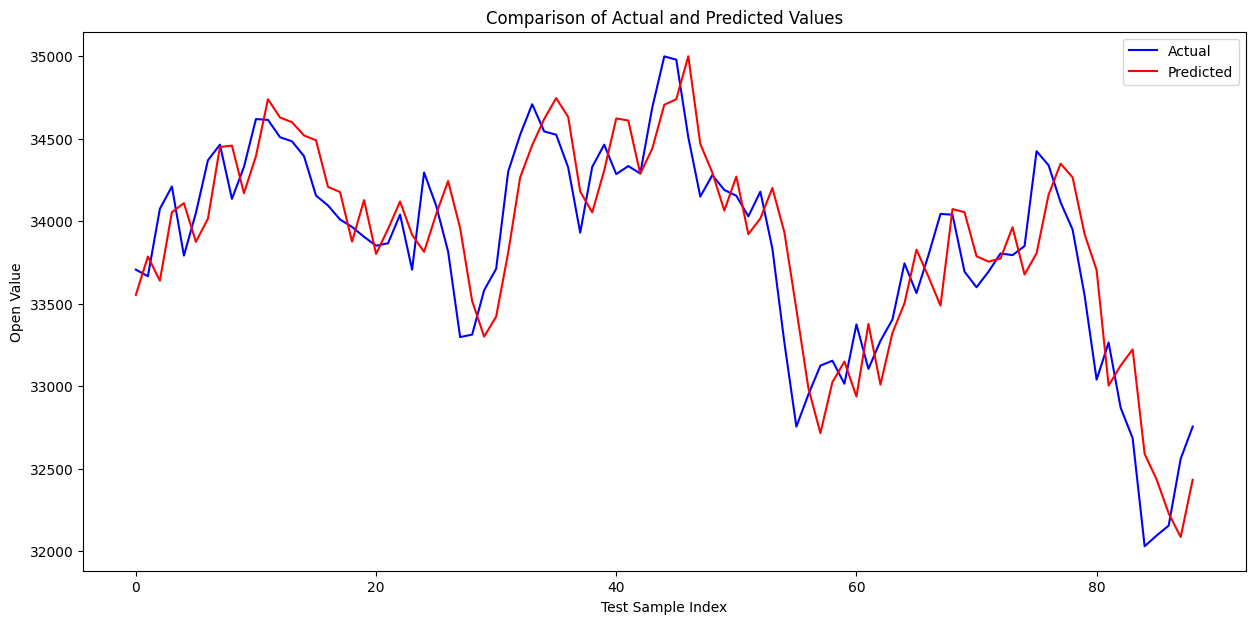

In [158]:
# 실제값과 예측값을 시각화하기 위한 인덱스 생성
test_indices = range(len(y_test[261:350]))

plt.figure(figsize=(15, 7))
plt.plot(test_indices, y_test[261:350], label='Actual', color='blue')
plt.plot(test_indices, y_pred[261:350].flatten(), label='Predicted', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Open Value')
plt.legend()
plt.show()